# 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv(r"D:\OMSA\CSE6242\Project\financial-news-dataset\Datasets\all_financial_news_master_stream.csv")
df.columns

C:\Users\mp094\AppData\Local\Temp\ipykernel_38816\3111571824.py:1: DtypeWarning: Columns (0,1,2,3,5,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"D:\OMSA\CSE6242\Project\financial-news-dataset\Datasets\all_financial_news_master_stream.csv")


Index(['uuid', 'url', 'site', 'site_full', 'title', 'author', 'published',
       'country', 'language', 'sentiment', 'category', 'text', 'stock'],
      dtype='object')

# 2. Output JSON for Gemini Training

In [ ]:
import pandas as pd
import json
import math
import os

# CONFIGURATION
CSV_PATH = r"D:\OMSA\CSE6242\Project\data\all_financial_news_master_stream.csv"   # path to your input CSV
TEXT_COLUMN = "title"                                       # column containing news headline text
OUTPUT_DIR = r"D:\OMSA\CSE6242\Project\data\jsonl_batches"  # output directory for JSONL files
BATCH_SIZE = 10_000                                         # 10K records per batch file
MAX_BATCHES = 20                                            # limit to 20 batches max

# CREATE OUTPUT DIRECTORY IF NEEDED
os.makedirs(OUTPUT_DIR, exist_ok=True)

# LOAD CSV
df = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df)} rows from {CSV_PATH}")

# TEMPLATE BUILDER
def make_jsonl_entry(text):
    return {
        "request": {
            "system_instruction": {
                "parts": [
                    {
                        "text": (
                            "You are a professional financial analyst. "
                            "You are an expert at analyzing sentiment from financial news headlines.\n"
                            "Classify the sentiment of the following financial news headline into exactly one of:\n"
                            "Very Negative; Negative; Somewhat Negative; Neutral; Somewhat Positive; Positive; Very Positive.\n"
                            "If you cannot determine the sentiment, reply “Unknown.”\n"
                            "Respond only in this format (no reasoning, no extra text):\n\n"
                            "Rating: <Your Label>"
                        )
                    }
                ]
            },
            "contents": [
                {
                    "role": "user",
                    "parts": [
                        {"text": f"Analyze the following article(s):\n\n{text.strip()}"}
                    ]
                }
            ],
        }
    }

# SPLIT INTO JSONL BATCH FILES
num_batches = min(math.ceil(len(df) / BATCH_SIZE), MAX_BATCHES)
print(f"Creating {num_batches} JSONL batch files (max {MAX_BATCHES})...")

for i in range(num_batches):
    start = i * BATCH_SIZE
    end = min(start + BATCH_SIZE, len(df))
    batch_df = df.iloc[start:end]

    output_path = os.path.join(OUTPUT_DIR, f"batch_{i+1:03}.jsonl")

    with open(output_path, "w", encoding="utf-8") as f:
        for _, row in batch_df.iterrows():
            title = str(row[TEXT_COLUMN]).strip()
            if title:
                json.dump(make_jsonl_entry(title), f, ensure_ascii=False)
                f.write("\n")

    print(f" Created {output_path} ({len(batch_df)} rows)")

print(f"Done {num_batches} JSONL files saved to:\n{OUTPUT_DIR}")


# 3. Take Predictions from Gemini and output to CSV for Sentiment model training

In [ ]:
import json
import pandas as pd

# path to your jsonl file
file_path = r"D:\OMSA\CSE6242\Project\data\cse6242team176outputs_prediction-model-2025-10-26T21_13_14.457767Z_predictions.jsonl"

titles = []
sentiments = []

with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue
        data = json.loads(line)

        # Extract the title (inside request.contents[0].parts[0].text)
        try:
            full_text = data["request"]["contents"][0]["parts"][0]["text"]
            title = full_text.split("Analyze the following article(s):")[-1].strip()
        except (KeyError, IndexError):
            title = None

        # Extract the sentiment prediction (inside response.output or response.content)
        sentiment = None
        if "response" in data:
            # handle OpenAI Batch API response format
            if "output" in data["response"]:
                text = data["response"]["output"][0]["content"][0]["text"]
                if "Rating:" in text:
                    sentiment = text.split("Rating:")[-1].strip()
            elif "content" in data["response"]:
                # fallback for slightly different structure
                text = data["response"]["content"][0]["text"]
                if "Rating:" in text:
                    sentiment = text.split("Rating:")[-1].strip()

        titles.append(title)
        sentiments.append(sentiment)

# Create a DataFrame and display / export
df = pd.DataFrame({"title": titles, "sentiment": sentiments})
print(df.head())

# Optional: save to CSV
df.to_csv(r"D:\OMSA\CSE6242\Project\data\sentiment_results.csv", index=False)
print("Exported sentiment_results.csv")


# 4. Training Sentiment model

In [10]:
# pip install torch torchvision torchaudio
# pip install scikit-learn
# pip install pandas
# pip install numpy
# pip install matplotlib
# pip install seaborn


In [ ]:
# Feed Forward Neural Network for Sentiment
#  No TF-IDF (learns embeddings)
#  Includes Confusion Matrix

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

# 1. Load Data
input_ = r"D:\OMSA\CSE6242\Project\data\sentiment_results.csv"

df = pd.read_csv(input_).dropna(subset=["title", "sentiment"])

# 2. Label Encode
le = LabelEncoder()
df["label"] = le.fit_transform(df["sentiment"])
num_classes = len(le.classes_)
print("Classes:", le.classes_)

# 3. Tokenization
def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text.split()

tokenized_titles = [tokenize(t) for t in df["title"]]

# 4. Build Vocabulary
vocab_counter = Counter()
for tokens in tokenized_titles:
    vocab_counter.update(tokens)

vocab = {word: i + 2 for i, (word, _) in enumerate(vocab_counter.most_common(10000))}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

def encode(tokens, vocab, max_len=30):
    ids = [vocab.get(t, 1) for t in tokens][:max_len]
    return ids + [0] * (max_len - len(ids))

encoded_titles = [encode(t, vocab) for t in tokenized_titles]

X = np.array(encoded_titles)
y = df["label"].values

# 5. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Torch Dataset
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SentimentDataset(X_train, y_train)
test_ds = SentimentDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64)

# 7. Define Model
class FFNN_Embedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.fc = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        embedded = self.embedding(x)                  # (batch, seq_len, embed_dim)
        avg_embedded = embedded.mean(dim=1)           # average pooling
        return self.fc(avg_embedded)

vocab_size = len(vocab)
model = FFNN_Embedding(vocab_size, embed_dim=100, hidden_dim=256, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 8. Training
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_dl):.4f}")

# 9. Evaluation
model.eval()
softmax = nn.Softmax(dim=1)
all_probs, all_preds, all_true = [], [], []

with torch.no_grad():
    for xb, yb in test_dl:
        logits = model(xb)
        probs = softmax(logits)
        preds = torch.argmax(probs, dim=1)
        all_probs.append(probs)
        all_preds.append(preds)
        all_true.append(yb)

probs = torch.cat(all_probs).numpy()
preds = torch.cat(all_preds).numpy()
true = torch.cat(all_true).numpy()

# 10. Sentiment Score (-100 to 100)
scores = []
for i, p in enumerate(preds):
    prob = probs[i, p]
    label = le.classes_[p]
    if "Negative" in label:
        score = -100 * prob
    elif "Positive" in label:
        score = 100 * prob
    else:
        score = 0
    scores.append(score)

# 11. Results DataFrame
results = pd.DataFrame({
    "headline": df.iloc[X_test.index].title.values,
    "true_label": le.inverse_transform(true),
    "pred_label": le.inverse_transform(preds),
    "confidence": np.max(probs, axis=1),
    "sentiment_score": scores
})

results.to_csv("sentiment_predictions.csv", index=False)
print("Saved predictions to sentiment_predictions.csv")

# 12. Confusion Matrix
cm = confusion_matrix(true, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 13. Classification Report
print("\nClassification Report:")
print(classification_report(true, preds, target_names=le.classes_))


# 6. Save Model Weights

In [ ]:
import joblib
import torch

# Save model weights
torch.save(model.state_dict(), "sentiment_ffnn_model.pt")

# Save vocab + label encoder
joblib.dump(vocab, "vocab.pkl")
joblib.dump(le, "label_encoder.pkl")

print("Model, vocab, and label encoder saved successfully!")


# 7. Label Training Set with Trained Sentiment Model

In [ ]:
# Sentiment Inference Pipeline (No Retraining)
# Keeps published, tickers, sectors, etc. from input CSV

import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import joblib
from tqdm import tqdm

tqdm.pandas()

# 1. Load Saved Components
vocab = joblib.load("vocab.pkl")
le = joblib.load("label_encoder.pkl")

# 2. Re-create Model Architecture
class FFNN_Embedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.fc = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        embedded = self.embedding(x)
        avg_embedded = embedded.mean(dim=1)
        return self.fc(avg_embedded)

# 3. Load Trained Weights
model = FFNN_Embedding(
    vocab_size=len(vocab),
    embed_dim=100,
    hidden_dim=256,
    num_classes=len(le.classes_)
)
model.load_state_dict(torch.load("sentiment_ffnn_model.pt", map_location="cpu"))
model.eval()

print("Model loaded and ready for inference.")

# 4. Preprocess + Prediction Functions
def preprocess_text(text, vocab, max_len=30):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    tokens = text.split()
    ids = [vocab.get(t, 1) for t in tokens][:max_len]
    ids += [0] * (max_len - len(ids))
    return torch.tensor([ids], dtype=torch.long)

def predict_sentiment(text):
    x = preprocess_text(text, vocab)
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1).numpy()[0]
        pred_idx = np.argmax(probs)
        label = le.inverse_transform([pred_idx])[0]
        confidence = float(probs[pred_idx])

        # Compute sentiment score (-100 to 100)
        if "negative" in label.lower():
            score = -100 * confidence
        elif "positive" in label.lower():
            score = 100 * confidence
        else:
            score = 0

    return {
        "label": label,
        "confidence": confidence,
        "score": score
    }

# 5. Load Target CSV
input_path = r"D:\OMSA\CSE6242\Project\data\merged_sentiment_news_with_tickers.csv"
df = pd.read_csv(input_path)
print(f"Loaded {len(df):,} rows")

# 6. Run Model
print("Running model inference")
results = df["title"].progress_apply(lambda t: predict_sentiment(str(t)))

# Split results into columns
df["sentiment_label"] = results.apply(lambda x: x["label"])
df["confidence"] = results.apply(lambda x: x["confidence"])
df["sentiment_score"] = results.apply(lambda x: x["score"])

# 7. Save Results
output_path = r"D:\OMSA\CSE6242\Project\data\merged_with_sentiment_labels.csv"
df.to_csv(output_path, index=False)

# 8. Confirm Results
print(f"\nSentiment labels and scores appended successfully")
print(f"Saved updated dataset to:\n{output_path}")
print(df[["title", "published", "tickers", "sectors", "sentiment_label", "sentiment_score", "confidence"]].head(10))


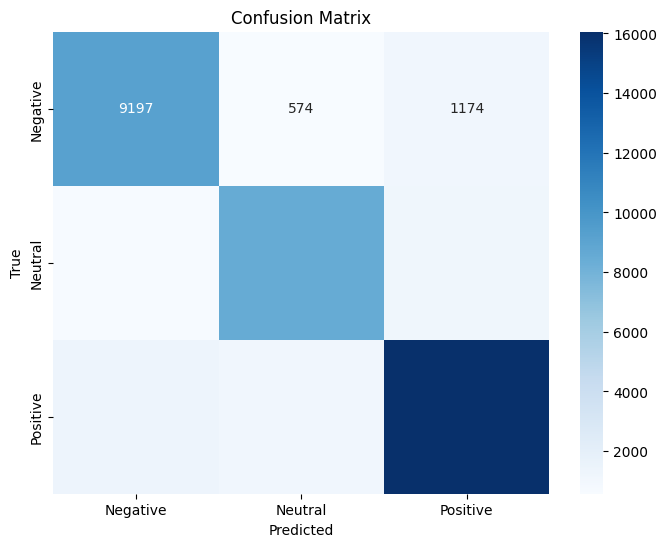


Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.84      0.83     10945
     Neutral       0.83      0.82      0.83     10363
    Positive       0.87      0.86      0.87     18593

    accuracy                           0.85     39901
   macro avg       0.84      0.84      0.84     39901
weighted avg       0.85      0.85      0.85     39901

